<a href="https://colab.research.google.com/github/xx529/Reinforcement-Learning/blob/main/DQN/DQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CartPole

1. DQN (double)
2. Q-Learning
3. memory replay

![jupyter](https://github.com/xx529/Reinforcement-Learning/blob/main/DQN/pole.png?raw=1)

In [16]:
import gym
import matplotlib.pyplot as plt
import random
import torch.nn as nn
import torch
import copy
import numpy as np
import torch.optim as optimizer
from IPython import display
import time

## Memory Replay

In [17]:
class MemoryReplay():
    def __init__(self, memory_size):
        self.queue = []
        self.memory_size = memory_size
        
    def add(self, mc_sample_tuple):
        if len(self.queue) >= self.memory_size:
            self.queue.pop(0)
        self.queue.append(mc_sample_tuple)
    
    def sample(self, batch_size):
        if batch_size > len(self.queue):
            return self.queue
        else:
            return random.sample(self.queue, batch_size)
        
    def __len__(self):
        return len(self.queue)

## DQN

In [18]:
class DQN(nn.Module):
    def __init__(self):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(5, 64)  # [position, velocity, action]
        self.fc2 = nn.Linear(64, 32)
        self.out = nn.Linear(32, 1)
        self.relu = nn.ReLU()

        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        return self.out(x)   

## Agent

In [19]:
class Agent():
    def __init__(self, DQN_value_net, DQN_target_net, update_per_epoch):
        self.target_net = DQN_target_net
        self.value_net = DQN_value_net
        self.loss_function = nn.MSELoss()
        self.optimizer = optimizer.Adam(self.value_net.parameters())
        
        self.action = np.array([0, 1])
        self.update_per_epoch = update_per_epoch
        self.count = 0
    
    
    def step(self, state_array, e_threshold, net='value', strategy='egreedy'):
        if strategy == 'egreedy':
            if random.random() > e_threshold:
                action = self.get_max_action(net, state_array)
            else:
                action = np.random.choice(self.action)

        elif strategy == 'max':
            action = self.get_max_action(net, state_array)

        return action
    
    
    def get_actions(self, net, state_array):
        
        # 构造数据
        data_batch = torch.Tensor([np.r_[state_array, x] for x in self.action])
        
        if net == 'value':
            actions = self.value_net(data_batch).squeeze()
        if net == 'target':
            actions = self.target_net(data_batch).squeeze()
            
        return actions
        
        
    def get_max_action(self, net, state_array):
        max_action = self.get_actions(net, state_array).topk(1)[1].item()
        return max_action
        
        
    def learn(self, data_batch, gamma):
        loss_rec = 0

        # features & label 构造
        x, y_true = self.creat_features_labels(data_batch, gamma)
        
        for i in range(100):
            # 清空梯度
            self.optimizer.zero_grad()
            
            # 训练
            y_pre = self.value_net(x)
            loss = self.loss_function(y_pre, y_true)
            loss_rec += loss.item()
            loss.backward()

        
        # 达到固定次数更新 target_net
        self.count += 1
        if self.count > self.update_per_epoch:
            self.update_target_net()
        
        return loss_rec / 100
        
        
    def creat_features_labels(self, data_batch, gamma):
        x = []
        y = []
        
        for data in data_batch:
            # x 构造
            x.append(np.r_[data[0], data[1]])
            
            # y 构造
            if  data[4]:  # done
                y.append(data[2])
            else:
                max_action_value = self.get_actions('target', data[3]).topk(1)[0].item()
                y.append(data[2] + gamma * max_action_value)
        
        return torch.Tensor(x), torch.Tensor(y).view(-1, 1)
        
    
    def update_target_net(self):
        self.target_net = copy.deepcopy(self.value_net).eval()
        self.count = 0

## Setting

In [28]:
# Envirement
envirement = gym.make('CartPole-v0')

# Replay
MEMORY_SIZE = 3000
replay = MemoryReplay(MEMORY_SIZE)

# DQN
model_value = DQN()
model_target = DQN()

# Agent
UPDATE_PER_EPOCH = 128
agent = Agent(model_value, model_target, UPDATE_PER_EPOCH)

# Others
E_THRESHOLD = 0.3
BATCH_SIZE = 1024
GAMMA = 0.8

## RL Training

In [29]:
loss_mean_list = []
reward_list = []


for i in range(10000):

    # 初始状态
    done = False
    current_state = envirement.reset()
    reward_temp = 0
    loss_list = []
    start = time.time()
#     E_THRESHOLD = 1 / 1 + (0.01*i)
    
    while not done :

        # agent 使用value_net 获取下一步 action
        action = agent.step(current_state, E_THRESHOLD, 'value', 'egreedy')

        # 从环境获取信息
        next_state, reward, done, info = envirement.step(action)
        reward_temp += reward

        # 增加经验
        replay.add((current_state, action, reward, next_state, done))

        # 提取经验
        data_batch = replay.sample(BATCH_SIZE)

        # 网络更新参数
        loss = agent.learn(data_batch, GAMMA)
        loss_list.append(loss)

        # 进入下一个状态
        current_state = next_state


    loss_mean_list.append(np.array(loss_list).mean())
    reward_list.append(reward_temp)
    duration = round(time.time() - start, 1)
    
    print(f'epoch: {i+1},  loss: {round(np.array(loss_list).mean(), 6)},  reward: {reward_temp},  second: {duration}')

#     # 展示loss曲线
#     plt.figure(figsize=(16, 8))
    
#     plt.subplot2grid((5,1), (0,0), 2)
#     plt.title('loss')
#     plt.plot(loss_mean_list, color='b')
    
#     plt.subplot2grid((5,1), (3,0), 2)
#     plt.title('reward')
#     plt.plot(reward_list, color='r')
    
#     display.display(plt.gcf())
#     display.clear_output(wait=True)

流式输出内容被截断，只能显示最后 5000 行内容。
epoch: 5001,  loss: 0.894422,  reward: 22.0,  second: 7.3
epoch: 5002,  loss: 0.894764,  reward: 22.0,  second: 7.4
epoch: 5003,  loss: 0.894375,  reward: 20.0,  second: 6.6
epoch: 5004,  loss: 0.895029,  reward: 22.0,  second: 7.4
epoch: 5005,  loss: 0.894784,  reward: 27.0,  second: 9.0
epoch: 5006,  loss: 0.893788,  reward: 14.0,  second: 4.6
epoch: 5007,  loss: 0.893828,  reward: 22.0,  second: 7.4
epoch: 5008,  loss: 0.895191,  reward: 24.0,  second: 8.0
epoch: 5009,  loss: 0.894295,  reward: 24.0,  second: 8.0
epoch: 5010,  loss: 0.89385,  reward: 25.0,  second: 8.2
epoch: 5011,  loss: 0.894504,  reward: 20.0,  second: 6.7
epoch: 5012,  loss: 0.894806,  reward: 18.0,  second: 5.9
epoch: 5013,  loss: 0.894604,  reward: 33.0,  second: 11.1
epoch: 5014,  loss: 0.894802,  reward: 20.0,  second: 6.7
epoch: 5015,  loss: 0.894113,  reward: 19.0,  second: 6.3
epoch: 5016,  loss: 0.894674,  reward: 24.0,  second: 7.9
epoch: 5017,  loss: 0.894613,  reward: 20.0, 

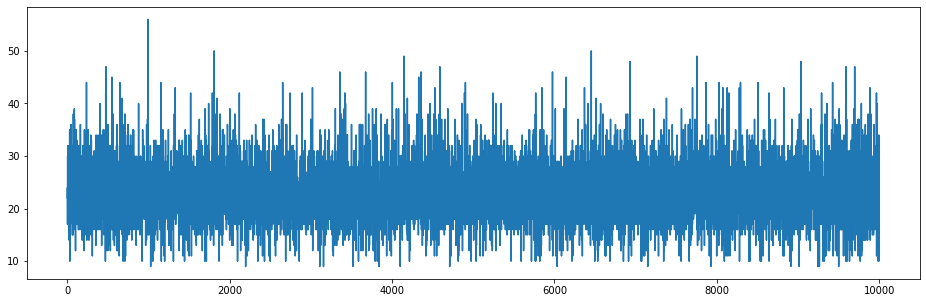

In [30]:
plt.figure(figsize=(16, 5))
plt.plot(reward_list)
plt.show()

## Playing

In [31]:
reward_list = []

for i in range(500):

    # 初始状态
    done = False
    current_state = envirement.reset()
    reward_temp = 0

    while not done :

        # agent 使用value_net 获取下一步 action
        action = agent.step(current_state, 0, 'value', 'max')

        # 从环境获取信息
        next_state, reward, done, info = envirement.step(action)
        reward_temp += reward

        # 进入下一个状态
        current_state = next_state
    reward_list.append(reward_temp)

print(np.array(reward_list).mean())

22.762


## Random Playing

In [32]:
reward_list = []

for i in range(500):
    
    # 初始状态
    done = False
    current_state = envirement.reset()
    reward_temp = 0

    while not done :
        action = random.choice([0,1])

        # 从环境获取信息
        next_state, reward, done, info = envirement.step(action)
        reward_temp += reward

        # 进入下一个状态
        current_state = next_state
        reward_list.append(reward_temp)

print(np.array(reward_list).mean())

14.097236250114774
